In [2]:
import pandas as pd
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt
import itertools 

ModuleNotFoundError: No module named 'community'

In [4]:
!pip install community

  Preparing metadata (setup.py) ... done
  Created wheel for community: filename=community-1.0.0b1-py3-none-any.whl size=2137 sha256=a6c2631cdf04678a55f264f4d54a79d72544f7733772b454d1266cd2f96eb569
  Stored in directory: /Users/kmt/Library/Caches/pip/wheels/1d/8c/5e/74907ee438b2ce993d5a7a92b9c2c40accd75150578d119ace
Successfully built community


In [6]:
import pandas as pd
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt
import itertools 

In [8]:
# --- Step 1: Data Loading and Preprocessing ---
# In a real scenario, you would load your dataset from Kaggle.
# Here, we'll create a sample DataFrame that mimics the structure
# of user-user and user-video interactions.

print("Step 1: Simulating data loading...")
# Sample data: user_id is the influencer, followed_by is a user,
# video_id is a video they posted, and liked_by is a user who liked that video.
data = {
    'tiktok_name': ['charlidamelio', 'khaby.lame', 'bellapoarch', 'addisonre', 'zachking', 'kimberly.loaiza', 'cznburak', 'therock'],
    'follower_count': [150, 161, 93, 88, 77, 73, 72, 70], # in millions
    'user_id': [1, 2, 3, 4, 5, 6, 7, 8],
    # Simulate some "follows" between these influencers for the graph
    'follows': [[2, 4], [1, 3, 5], [2, 8], [1], [2, 6], [5, 7], [6, 8], [3, 7]],
    # Simulate some popular videos and who liked them
    'video_id': ['v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8'],
    'liked_by_users': [[2, 3, 4], [1, 5, 6], [1, 4, 8], [1, 2], [2, 6, 7], [5, 7], [6, 8], [3, 7]]
}
df = pd.DataFrame(data)
print("Sample Data:")
print(df[['tiktok_name', 'follower_count', 'user_id']])
print("\n")


# --- Step 2: Graph Creation ---
# We will create a User-User graph based on "follows".
# In a full implementation, you would create a heterogeneous graph with users, videos, and hashtags.
print("Step 2: Building the social network graph...")
G = nx.Graph()

# Add users as nodes
for index, row in df.iterrows():
    G.add_node(row['user_id'], name=row['tiktok_name'], followers=row['follower_count'])

# Add "follows" as edges
for index, row in df.iterrows():
    user = row['user_id']
    for followed_user in row['follows']:
        G.add_edge(user, followed_user, type='follows')

# Add "likes" as weighted edges (more likes between users' content = stronger connection)
# This creates an implicit connection between users who like the same things.
user_likes = {}
for index, row in df.iterrows():
    video_creator = row['user_id']
    for user_who_liked in row['liked_by_users']:
        # We need to ensure the user who liked the content is also in our graph
        if not G.has_node(user_who_liked):
            G.add_node(user_who_liked, name=f'user_{user_who_liked}') # Add them as a general user

        # Create an edge between the video creator and the user who liked the content
        if G.has_edge(video_creator, user_who_liked):
            G[video_creator][user_who_liked].setdefault('weight', 0)
            G[video_creator][user_who_liked]['weight'] += 1 # Increase weight for each interaction
        else:
            G.add_edge(video_creator, user_who_liked, type='content_interaction', weight=1)


print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
print("\n")


# --- Step 3: Centrality Measures (as per your PDF) ---
# Using PageRank and Betweenness to find key influencers.
print("Step 3: Calculating Centrality Measures...")

# PageRank: Identifies nodes that are important based on the structure of incoming links.
pagerank = nx.pagerank(G, weight='weight')
# Sort by PageRank score
sorted_pagerank = sorted(pagerank.items(), key=lambda item: item[1], reverse=True)
print("Top 5 Influential Users (by PageRank):")
for user_id, score in sorted_pagerank[:5]:
    print(f"- {G.nodes[user_id].get('name', f'user_{user_id}')}: Score {score:.4f}")

# Betweenness Centrality: Identifies nodes that act as bridges between different parts of the network.
betweenness = nx.betweenness_centrality(G, weight='weight')
sorted_betweenness = sorted(betweenness.items(), key=lambda item: item[1], reverse=True)
print("\nTop 5 Bridge Users (by Betweenness Centrality):")
for user_id, score in sorted_betweenness[:5]:
    print(f"- {G.nodes[user_id].get('name', f'user_{user_id}')}: Score {score:.4f}")
print("\n")


# --- Step 4: Community Detection (as per your PDF) ---
# Using the Louvain method to find communities (friend groups).
print("Step 4: Detecting communities using the Louvain method...")
# Note: The Louvain algorithm works best on unweighted graphs for its standard implementation.
# For a weighted graph, the algorithm uses the weights to measure community density.
partition = community_louvain.best_partition(G, weight='weight')

# Group nodes by community
communities = {}
for node, community_id in partition.items():
    communities.setdefault(community_id, []).append(node)

print(f"Detected {len(communities)} communities.")
# Print the largest 3 communities
sorted_communities = sorted(communities.values(), key=len, reverse=True)
for i, community in enumerate(sorted_communities[:3]):
    community_names = [G.nodes[node].get('name', f'user_{node}') for node in community]
    print(f"- Community {i+1}: {community_names}")
print("\n")


# --- Step 5: Link Prediction (as per your PDF) ---
# Predict future connections (e.g., who a user might follow next).
# We'll use the Jaccard Coefficient, which measures the similarity between node neighborhoods.
print("Step 5: Predicting potential new links (follows)...")
# The Jaccard Coefficient is calculated for pairs of nodes that are not currently connected.
predictions = nx.jaccard_coefficient(G, ebunch=nx.non_edges(G))

# Sort potential links by their Jaccard score
sorted_predictions = sorted(predictions, key=lambda item: item[2], reverse=True)

print("Top 5 potential new connections (friend recommendations):")
for u, v, score in sorted_predictions[:5]:
    user_u_name = G.nodes[u].get('name', f'user_{u}')
    user_v_name = G.nodes[v].get('name', f'user_{v}')
    if score > 0:
        print(f"- Potential link between {user_u_name} and {user_v_name} with score: {score:.4f}")
print("\n")


# --- Step 6: Generating "For You Page" Recommendations ---
# This function combines the above analysis to recommend content.
print("Step 6: Generating FYP Recommendations...")

def generate_fyp_recommendations(user_id, graph, communities_partition, num_recommendations=3):
    """
    Generates FYP recommendations for a user.
    Logic:
    1. Find the user's community.
    2. Find the most influential users (by PageRank) within that community.
    3. Find content liked by those influential users.
    4. Recommend content that the target user has not yet interacted with.
    """
    if user_id not in graph:
        return f"User {user_id} not found in the network."

    recommendations = []
    # 1. Find the user's community
    user_community_id = communities_partition[user_id]
    community_nodes = [node for node, cid in communities_partition.items() if cid == user_community_id]

    # 2. Find influential users in that community
    community_pagerank = {node: pagerank[node] for node in community_nodes if node != user_id}
    # Sort them by influence
    influencers_in_community = sorted(community_pagerank.items(), key=lambda item: item[1], reverse=True)

    # 3. Find content created or liked by these influencers
    potential_videos = {}
    for influencer_id, score in influencers_in_community:
        # Find videos created by this influencer
        creator_info = df[df['user_id'] == influencer_id]
        if not creator_info.empty:
            video = creator_info.iloc[0]['video_id']
            potential_videos[video] = score # Weight recommendation by influencer's score

    # 4. Filter out content the user has already interacted with
    # Get videos created by the user or that the user has liked
    viewed_content = set()
    user_created_video = df[df['user_id'] == user_id]
    if not user_created_video.empty:
        viewed_content.add(user_created_video.iloc[0]['video_id'])

    for _, row in df.iterrows():
        if user_id in row['liked_by_users']:
            viewed_content.add(row['video_id'])

    # Sort final recommendations by influence score
    sorted_recommendations = sorted(potential_videos.items(), key=lambda item: item[1], reverse=True)
    
    final_recs = [video for video, score in sorted_recommendations if video not in viewed_content]

    return final_recs[:num_recommendations]

# --- Example: Get recommendations for User 1 (charlidamelio) ---
target_user = 1
recommendations = generate_fyp_recommendations(target_user, G, partition)
user_name = G.nodes[target_user]['name']
print(f"Recommendations for {user_name}: {recommendations}")

# --- Example: Get recommendations for User 8 (therock) ---
target_user_2 = 8
recommendations_2 = generate_fyp_recommendations(target_user_2, G, partition)
user_name_2 = G.nodes[target_user_2]['name']
print(f"Recommendations for {user_name_2}: {recommendations_2}")

# --- Visualize the Graph (Optional) ---
plt.figure(figsize=(12, 12))
# Color nodes by community
node_colors = [partition[node] for node in G.nodes()]
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color=node_colors, cmap=plt.cm.jet, labels={node: G.nodes[node].get('name', f'user_{node}') for node in G.nodes()})
plt.title("Social Network Graph with Communities")
plt.show()

Step 1: Simulating data loading...
Sample Data:
       tiktok_name  follower_count  user_id
0    charlidamelio             150        1
1       khaby.lame             161        2
2      bellapoarch              93        3
3        addisonre              88        4
4         zachking              77        5
5  kimberly.loaiza              73        6
6         cznburak              72        7
7          therock              70        8


Step 2: Building the social network graph...
Graph created with 8 nodes and 13 edges.


Step 3: Calculating Centrality Measures...
Top 5 Influential Users (by PageRank):
- khaby.lame: Score 0.1598
- bellapoarch: Score 0.1409
- charlidamelio: Score 0.1389
- cznburak: Score 0.1227
- kimberly.loaiza: Score 0.1205

Top 5 Bridge Users (by Betweenness Centrality):
- khaby.lame: Score 0.4365
- bellapoarch: Score 0.1667
- zachking: Score 0.0873
- kimberly.loaiza: Score 0.0873
- cznburak: Score 0.0714


Step 4: Detecting communities using the Louvain method

AttributeError: module 'community' has no attribute 'best_partition'

In [10]:
!pip uninstall community
!pip install python-louvain

Found existing installation: community 1.0.0b1
Uninstalling community-1.0.0b1:
  Would remove:
    /opt/anaconda3/lib/python3.12/site-packages/community-1.0.0b1.dist-info/*
    /opt/anaconda3/lib/python3.12/site-packages/community/*
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.6/204.6 kB 889.6 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9389 sha256=611c846441df87dc807717a62a1d3a023581cee572f7c5354f64d0ebbfc5698a
  Stored in directory: /Users/kmt/Library/Caches/pip/wheels/40/f1/e3/485b698c520fa0baee1d07897abc7b8d6479b7d199ce96f4af
Successfully built python-louvain


In [11]:
y

NameError: name 'y' is not defined

In [ ]:
Y

In [ ]:
!pip install python-louvain

Step 1: Simulating data loading...
Sample Data:
       tiktok_name  follower_count  user_id
0    charlidamelio             150        1
1       khaby.lame             161        2
2      bellapoarch              93        3
3        addisonre              88        4
4         zachking              77        5
5  kimberly.loaiza              73        6
6         cznburak              72        7
7          therock              70        8


Step 2: Building the social network graph...
Graph created with 8 nodes and 13 edges.


Step 3: Calculating Centrality Measures...
Top 5 Influential Users (by PageRank):
- khaby.lame: Score 0.1598
- bellapoarch: Score 0.1409
- charlidamelio: Score 0.1389
- cznburak: Score 0.1227
- kimberly.loaiza: Score 0.1205

Top 5 Bridge Users (by Betweenness Centrality):
- khaby.lame: Score 0.4365
- bellapoarch: Score 0.1667
- zachking: Score 0.0873
- kimberly.loaiza: Score 0.0873
- cznburak: Score 0.0714


Step 4: Detecting communities using the Louvain method

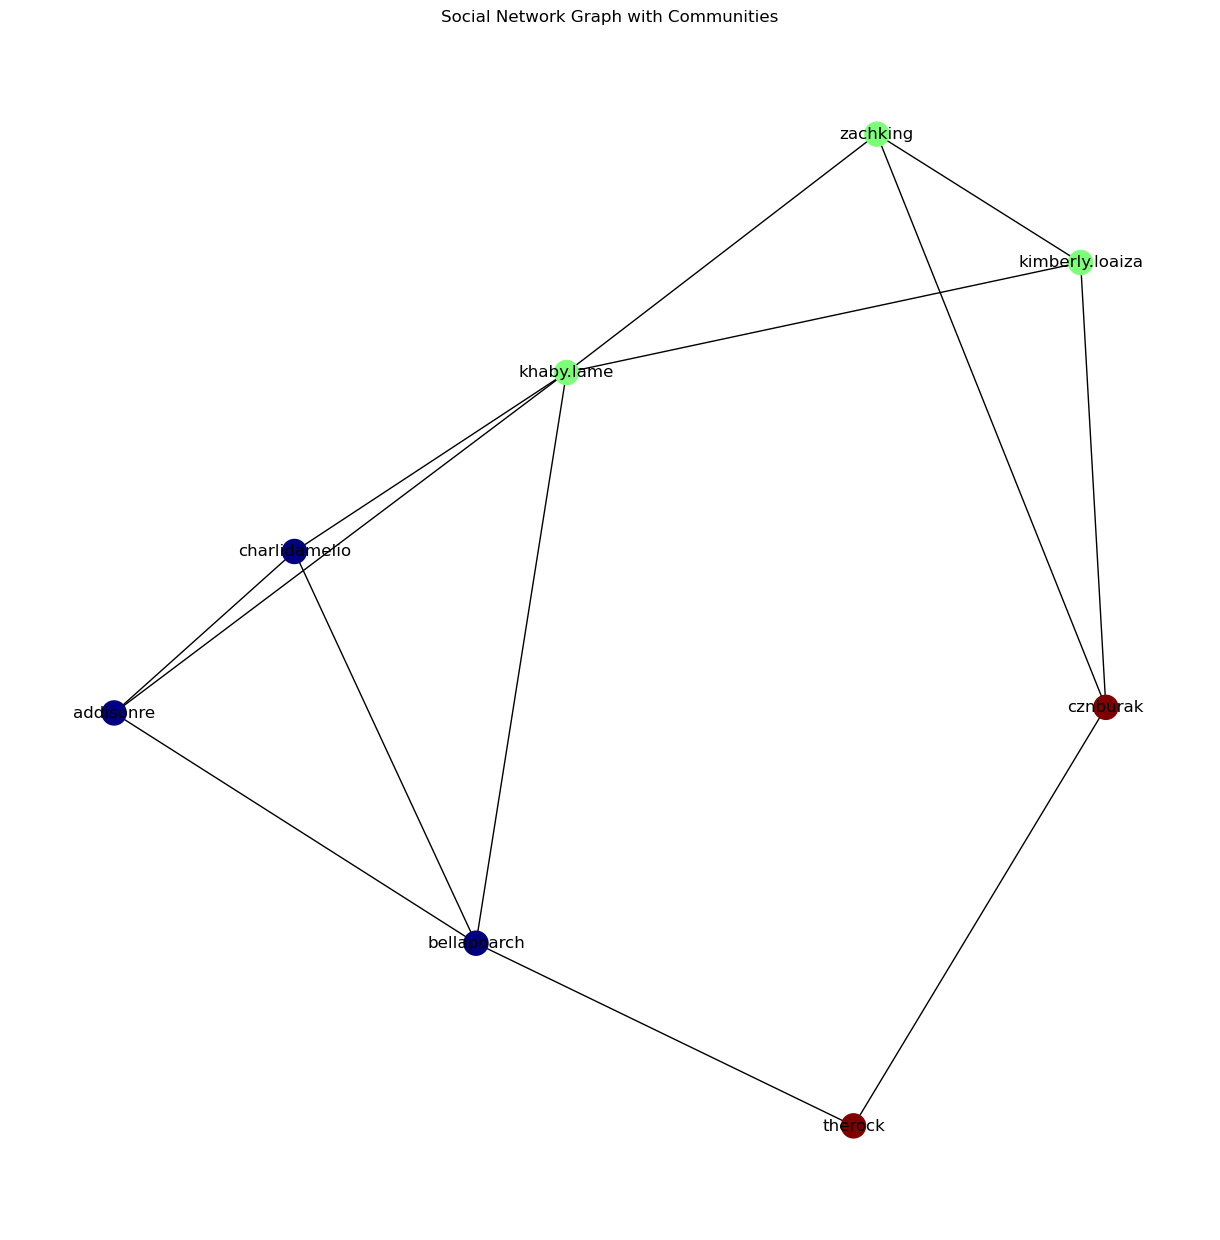

In [15]:
import pandas as pd
import networkx as nx
# CORRECTED IMPORT: Use a more specific import to avoid conflicts
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
import itertools # Used for link prediction

# --- Step 1: Data Loading and Preprocessing ---
print("Step 1: Simulating data loading...")
data = {
    'tiktok_name': ['charlidamelio', 'khaby.lame', 'bellapoarch', 'addisonre', 'zachking', 'kimberly.loaiza', 'cznburak', 'therock'],
    'follower_count': [150, 161, 93, 88, 77, 73, 72, 70], # in millions
    'user_id': [1, 2, 3, 4, 5, 6, 7, 8],
    'follows': [[2, 4], [1, 3, 5], [2, 8], [1], [2, 6], [5, 7], [6, 8], [3, 7]],
    'video_id': ['v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8'],
    'liked_by_users': [[2, 3, 4], [1, 5, 6], [1, 4, 8], [1, 2], [2, 6, 7], [5, 7], [6, 8], [3, 7]]
}
df = pd.DataFrame(data)
print("Sample Data:")
print(df[['tiktok_name', 'follower_count', 'user_id']])
print("\n")


# --- Step 2: Graph Creation ---
print("Step 2: Building the social network graph...")
G = nx.Graph()

# Add users as nodes
for index, row in df.iterrows():
    G.add_node(row['user_id'], name=row['tiktok_name'], followers=row['follower_count'])

# Add "follows" as edges
for index, row in df.iterrows():
    user = row['user_id']
    for followed_user in row['follows']:
        G.add_edge(user, followed_user, type='follows')

# Add "likes" as weighted edges
user_likes = {}
for index, row in df.iterrows():
    video_creator = row['user_id']
    for user_who_liked in row['liked_by_users']:
        if not G.has_node(user_who_liked):
            G.add_node(user_who_liked, name=f'user_{user_who_liked}')

        if G.has_edge(video_creator, user_who_liked):
            G[video_creator][user_who_liked].setdefault('weight', 0)
            G[video_creator][user_who_liked]['weight'] += 1
        else:
            G.add_edge(video_creator, user_who_liked, type='content_interaction', weight=1)


print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
print("\n")


# --- Step 3: Centrality Measures ---
print("Step 3: Calculating Centrality Measures...")
pagerank = nx.pagerank(G, weight='weight')
sorted_pagerank = sorted(pagerank.items(), key=lambda item: item[1], reverse=True)
print("Top 5 Influential Users (by PageRank):")
for user_id, score in sorted_pagerank[:5]:
    print(f"- {G.nodes[user_id].get('name', f'user_{user_id}')}: Score {score:.4f}")

betweenness = nx.betweenness_centrality(G, weight='weight')
sorted_betweenness = sorted(betweenness.items(), key=lambda item: item[1], reverse=True)
print("\nTop 5 Bridge Users (by Betweenness Centrality):")
for user_id, score in sorted_betweenness[:5]:
    print(f"- {G.nodes[user_id].get('name', f'user_{user_id}')}: Score {score:.4f}")
print("\n")


# --- Step 4: Community Detection (Corrected) ---
print("Step 4: Detecting communities using the Louvain method...")
# THIS IS THE CORRECTED LINE: Call the function from the imported module
partition = community_louvain.best_partition(G, weight='weight')

communities = {}
for node, community_id in partition.items():
    communities.setdefault(community_id, []).append(node)

print(f"Detected {len(communities)} communities.")
sorted_communities = sorted(communities.values(), key=len, reverse=True)
for i, community in enumerate(sorted_communities[:3]):
    community_names = [G.nodes[node].get('name', f'user_{node}') for node in community]
    print(f"- Community {i+1}: {community_names}")
print("\n")


# --- Step 5: Link Prediction ---
print("Step 5: Predicting potential new links (follows)...")
predictions = nx.jaccard_coefficient(G, ebunch=nx.non_edges(G))
sorted_predictions = sorted(predictions, key=lambda item: item[2], reverse=True)

print("Top 5 potential new connections (friend recommendations):")
for u, v, score in sorted_predictions[:5]:
    user_u_name = G.nodes[u].get('name', f'user_{u}')
    user_v_name = G.nodes[v].get('name', f'user_{v}')
    if score > 0:
        print(f"- Potential link between {user_u_name} and {user_v_name} with score: {score:.4f}")
print("\n")


# --- Step 6: Generating "For You Page" Recommendations ---
print("Step 6: Generating FYP Recommendations...")

def generate_fyp_recommendations(user_id, graph, communities_partition, num_recommendations=3):
    if user_id not in graph:
        return f"User {user_id} not found in the network."

    user_community_id = communities_partition[user_id]
    community_nodes = [node for node, cid in communities_partition.items() if cid == user_community_id]
    community_pagerank = {node: pagerank[node] for node in community_nodes if node != user_id}
    influencers_in_community = sorted(community_pagerank.items(), key=lambda item: item[1], reverse=True)

    potential_videos = {}
    for influencer_id, score in influencers_in_community:
        creator_info = df[df['user_id'] == influencer_id]
        if not creator_info.empty:
            video = creator_info.iloc[0]['video_id']
            potential_videos[video] = score

    viewed_content = set()
    user_created_video = df[df['user_id'] == user_id]
    if not user_created_video.empty:
        viewed_content.add(user_created_video.iloc[0]['video_id'])
    for _, row in df.iterrows():
        if user_id in row['liked_by_users']:
            viewed_content.add(row['video_id'])

    sorted_recommendations = sorted(potential_videos.items(), key=lambda item: item[1], reverse=True)
    final_recs = [video for video, score in sorted_recommendations if video not in viewed_content]
    return final_recs[:num_recommendations]

# --- Example: Get recommendations for User 1 (charlidamelio) ---
target_user = 1
recommendations = generate_fyp_recommendations(target_user, G, partition)
user_name = G.nodes[target_user]['name']
print(f"Recommendations for {user_name}: {recommendations}")

# --- Example: Get recommendations for User 8 (therock) ---
target_user_2 = 8
recommendations_2 = generate_fyp_recommendations(target_user_2, G, partition)
user_name_2 = G.nodes[target_user_2]['name']
print(f"Recommendations for {user_name_2}: {recommendations_2}")

# --- Visualize the Graph (Optional) ---
plt.figure(figsize=(12, 12))
node_colors = [partition[node] for node in G.nodes()]
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color=node_colors, cmap=plt.cm.jet, labels={node: G.nodes[node].get('name', f'user_{node}') for node in G.nodes()})
plt.title("Social Network Graph with Communities")
plt.show()

--- Steps 1 & 2: Loading Data and Building Graph ---
Graph created successfully.

--- Steps 3 & 4: Calculating Centrality and Communities ---
Calculations complete.

--- Generating Advanced Graphs ---


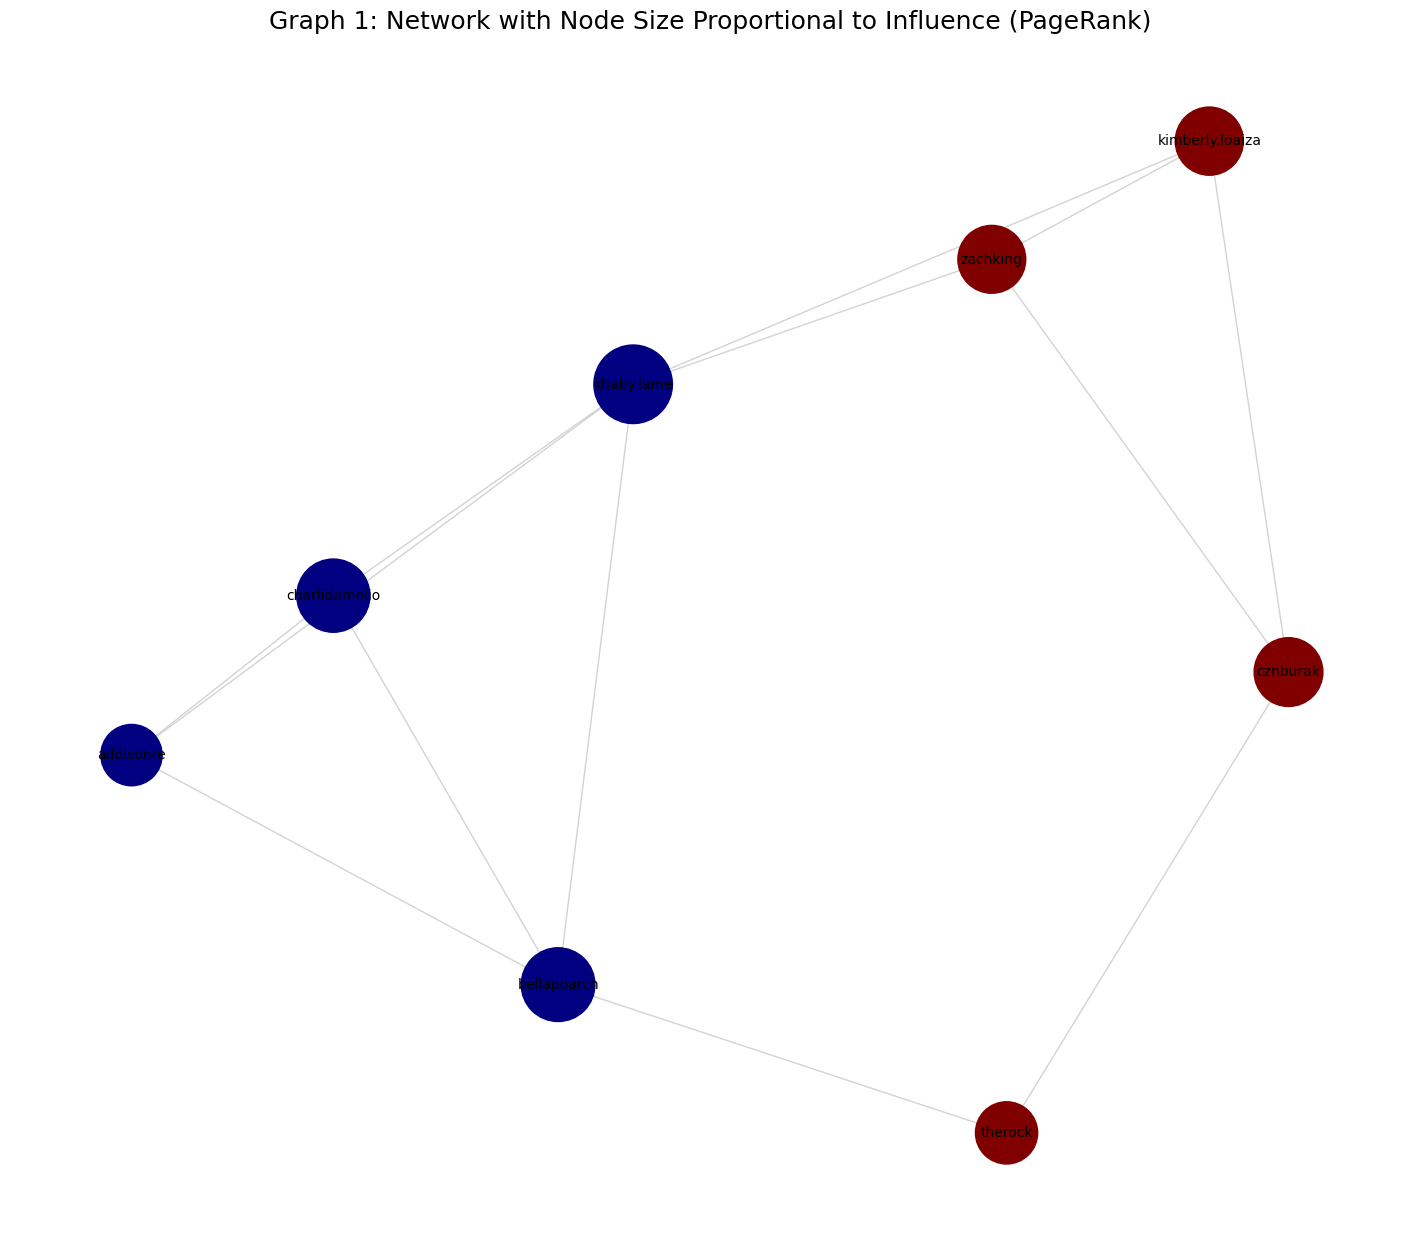

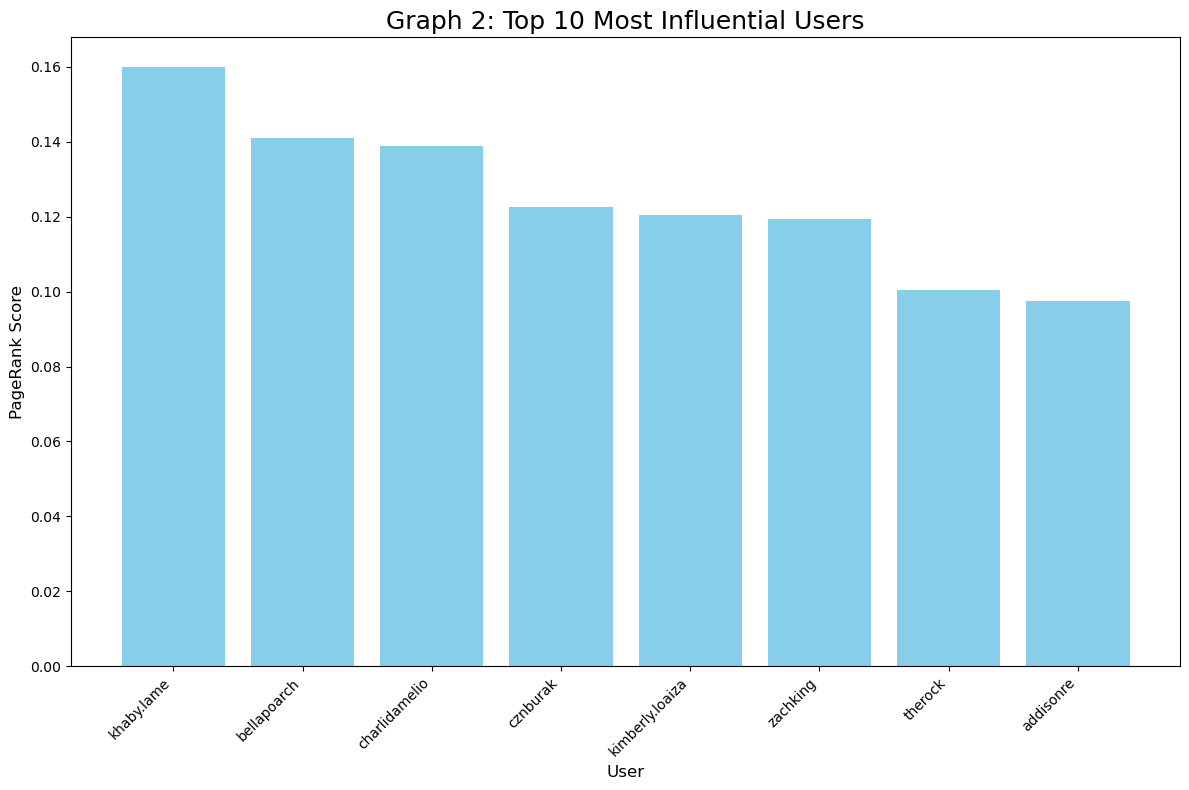

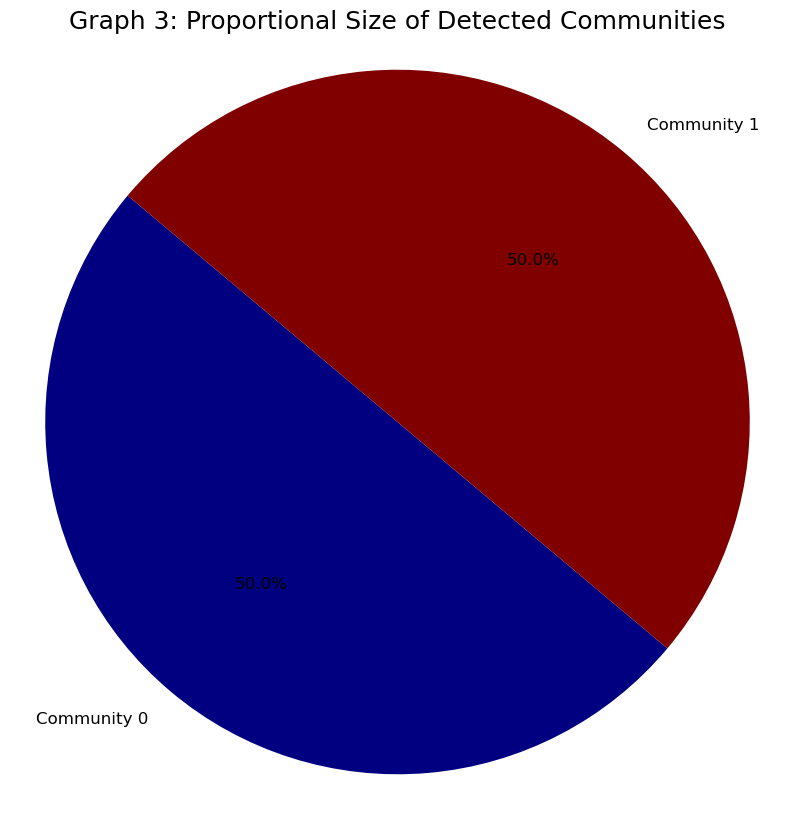

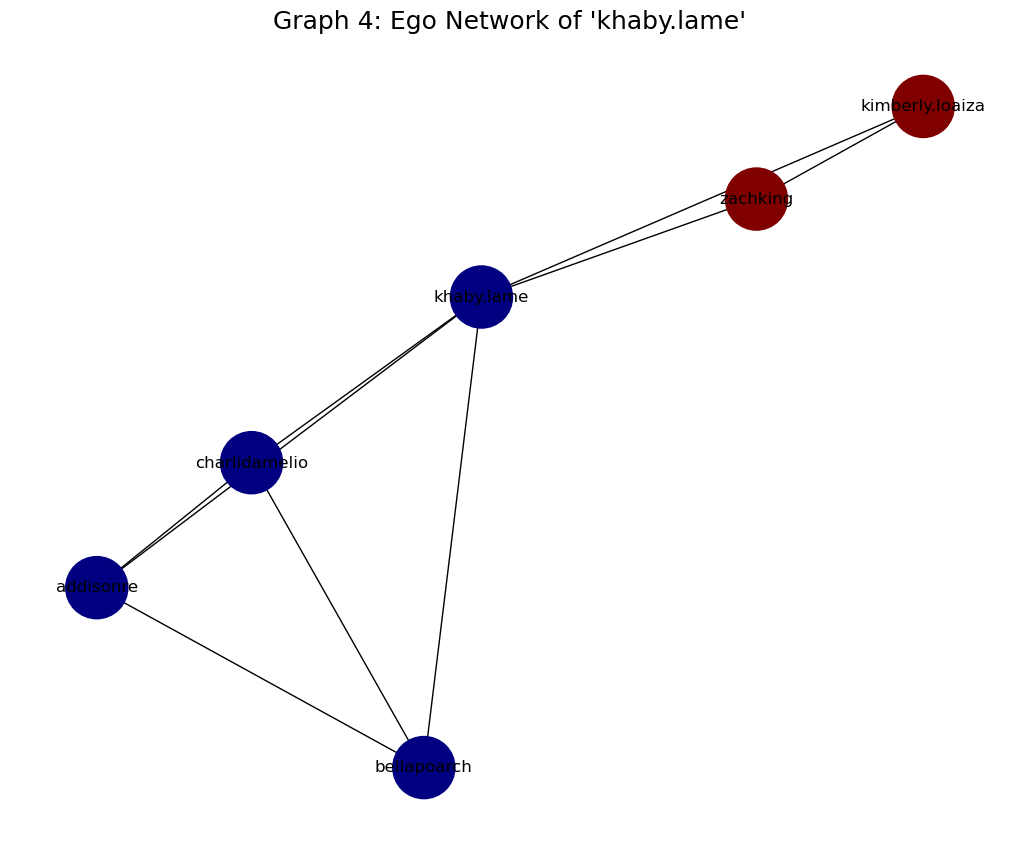

In [1]:
import pandas as pd
import networkx as nx
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
import numpy as np # Needed for new graphs

# --- Step 1 & 2: Data Loading and Graph Creation (Same as before) ---
print("--- Steps 1 & 2: Loading Data and Building Graph ---")
data = {
    'tiktok_name': ['charlidamelio', 'khaby.lame', 'bellapoarch', 'addisonre', 'zachking', 'kimberly.loaiza', 'cznburak', 'therock'],
    'follower_count': [150, 161, 93, 88, 77, 73, 72, 70],
    'user_id': [1, 2, 3, 4, 5, 6, 7, 8],
    'follows': [[2, 4], [1, 3, 5], [2, 8], [1], [2, 6], [5, 7], [6, 8], [3, 7]],
    'video_id': ['v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8'],
    'liked_by_users': [[2, 3, 4], [1, 5, 6], [1, 4, 8], [1, 2], [2, 6, 7], [5, 7], [6, 8], [3, 7]]
}
df = pd.DataFrame(data)
G = nx.Graph()

for index, row in df.iterrows():
    G.add_node(row['user_id'], name=row['tiktok_name'], followers=row['follower_count'])

for index, row in df.iterrows():
    user = row['user_id']
    for followed_user in row['follows']:
        G.add_edge(user, followed_user, type='follows')

for index, row in df.iterrows():
    video_creator = row['user_id']
    for user_who_liked in row['liked_by_users']:
        if not G.has_node(user_who_liked):
            G.add_node(user_who_liked, name=f'user_{user_who_liked}')
        if G.has_edge(video_creator, user_who_liked):
            G[video_creator][user_who_liked].setdefault('weight', 0)
            G[video_creator][user_who_liked]['weight'] += 1
        else:
            G.add_edge(video_creator, user_who_liked, type='content_interaction', weight=1)

print("Graph created successfully.\n")

# --- Step 3 & 4: SNA Calculations (Same as before) ---
print("--- Steps 3 & 4: Calculating Centrality and Communities ---")
pagerank = nx.pagerank(G, weight='weight')
partition = community_louvain.best_partition(G, weight='weight')
print("Calculations complete.\n")


# --- NEW: Advanced and More Relevant Graphing ---
print("--- Generating Advanced Graphs ---")

# We will use a consistent position layout for all network graphs
pos = nx.spring_layout(G, seed=42, k=0.8) # k adjusts the distance between nodes

# Graph 1: Network with Node Size Proportional to PageRank
# This visually emphasizes the most influential nodes.
plt.figure(figsize=(14, 12))
node_sizes = [pagerank[node] * 20000 for node in G.nodes()] # Scale sizes for visibility
node_colors = [partition[node] for node in G.nodes()]
labels = {node: G.nodes[node].get('name', f'user_{node}') for node in G.nodes()}

nx.draw(G, pos, with_labels=True, labels=labels, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.jet, font_size=10, edge_color='lightgray')
plt.title("Graph 1: Network with Node Size Proportional to Influence (PageRank)", size=18)
plt.show()

# Graph 2: Bar Chart of Top Influencers by Centrality
# A bar chart is often clearer than a complex network for comparing influence.
plt.figure(figsize=(12, 8))
sorted_pagerank = sorted(pagerank.items(), key=lambda item: item[1], reverse=True)[:10]
user_names = [G.nodes[user_id].get('name', f'user_{user_id}') for user_id, score in sorted_pagerank]
scores = [score for user_id, score in sorted_pagerank]

plt.bar(user_names, scores, color='skyblue')
plt.xlabel("User", size=12)
plt.ylabel("PageRank Score", size=12)
plt.title("Graph 2: Top 10 Most Influential Users", size=18)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Graph 3: Pie Chart of Community Sizes
# This graph gives a high-level overview of the community structure.
community_counts = {}
for community_id in partition.values():
    community_counts[community_id] = community_counts.get(community_id, 0) + 1

labels = [f'Community {id}' for id in community_counts.keys()]
sizes = list(community_counts.values())
colors = plt.cm.jet(np.linspace(0, 1, len(sizes)))

plt.figure(figsize=(10, 10))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 12})
plt.title("Graph 3: Proportional Size of Detected Communities", size=18)
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Graph 4: Ego Network for a Specific User
# This focuses on a single user and their direct connections.
def plot_ego_network(graph, user_id):
    ego_graph = nx.ego_graph(graph, user_id, radius=1) # Radius=1 means immediate neighbors
    
    plt.figure(figsize=(10, 8))
    ego_pos = {node: pos[node] for node in ego_graph.nodes()} # Use original positions for consistency
    
    node_colors = [partition[node] for node in ego_graph.nodes()]
    labels = {node: G.nodes[node].get('name', f'user_{node}') for node in ego_graph.nodes()}

    nx.draw(ego_graph, ego_pos, with_labels=True, labels=labels, node_color=node_colors, cmap=plt.cm.jet, node_size=2000, font_size=12)
    
    center_node_name = graph.nodes[user_id].get('name')
    plt.title(f"Graph 4: Ego Network of '{center_node_name}'", size=18)
    plt.show()

# Example: Plot the ego network for user 2 ('khaby.lame')
plot_ego_network(G, user_id=2)

--- Step 1: Loading Real Influencer Data ---
Successfully loaded tiktok_top_1000.csv
Loaded 200 influencer records.

--- Step 2: Building Graph from Real Data ---
Simulating network edges (follows)...
Graph created with 199 nodes and 637 edges.

--- Steps 3 & 4: Calculating Centrality and Communities ---
Calculations complete.

--- Generating Advanced Graphs ---


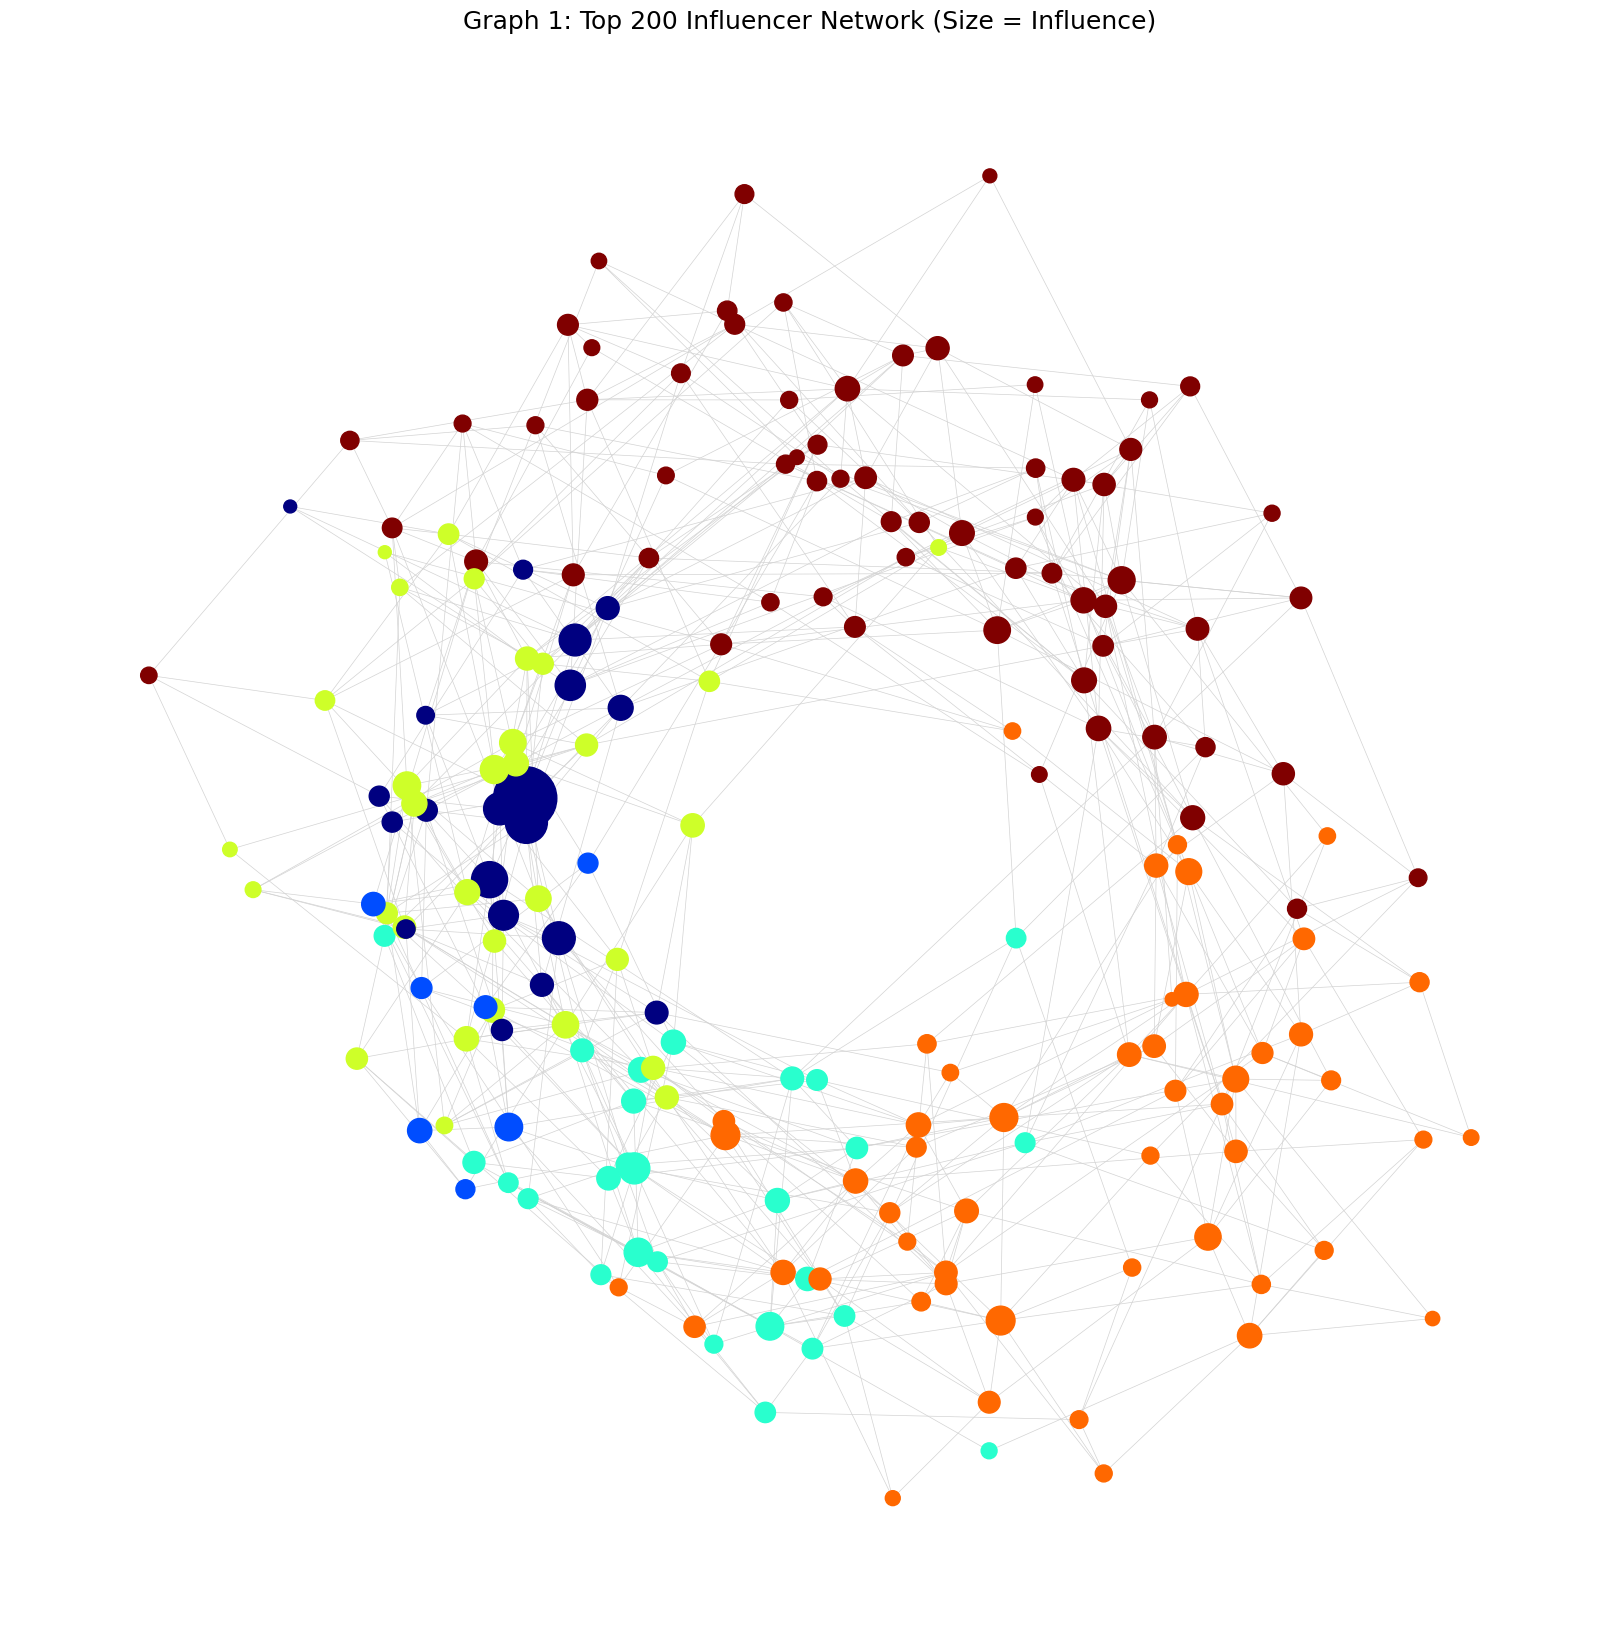

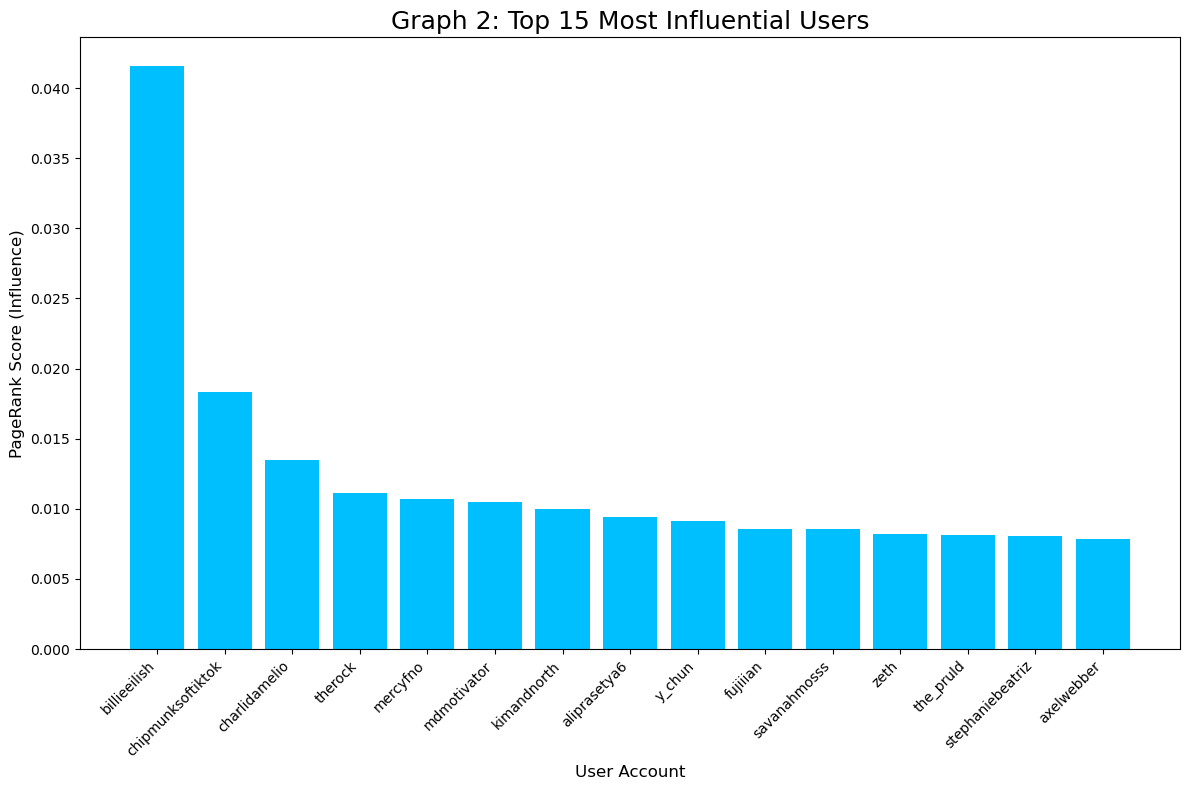

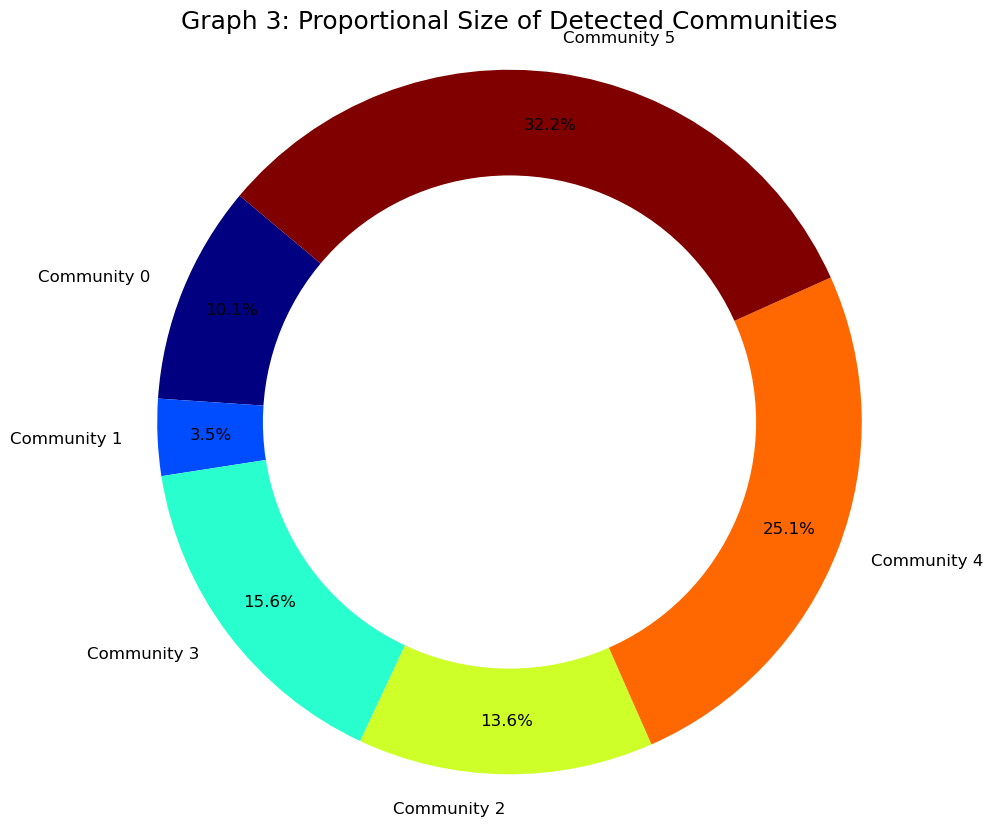

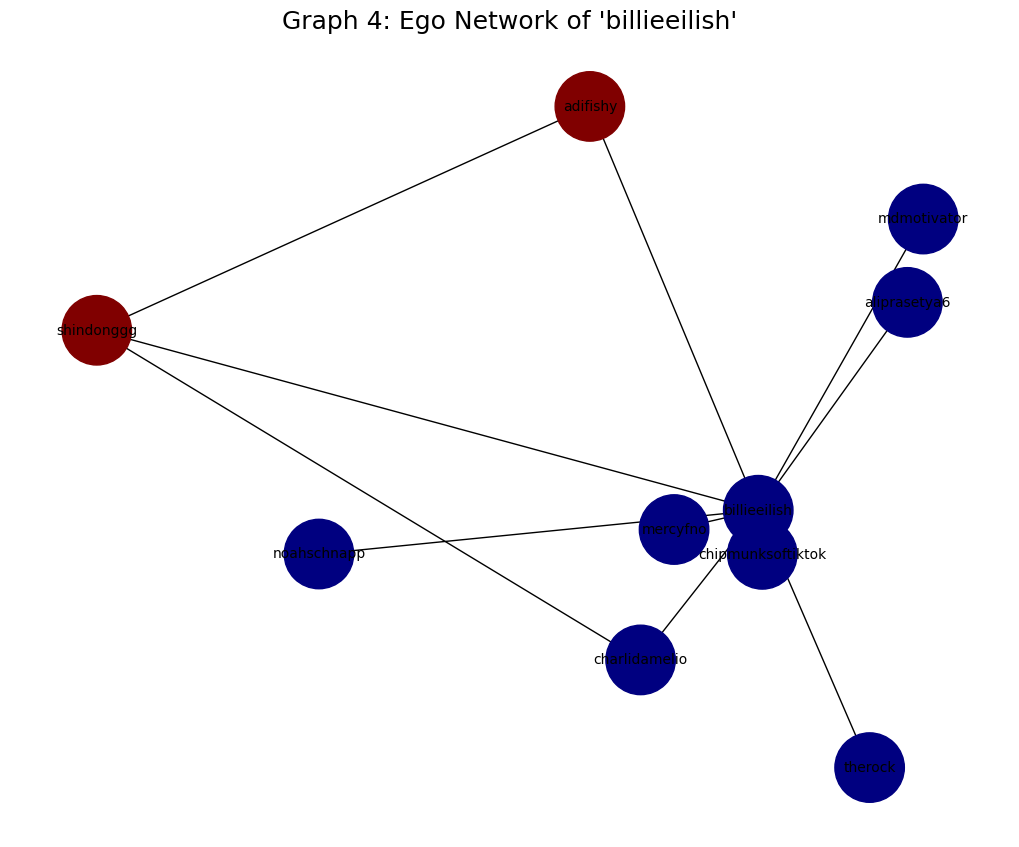

In [1]:
import pandas as pd
import networkx as nx
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
import numpy as np
import random

# --- Step 1: Load Real Dataset from Kaggle CSV ---
print("--- Step 1: Loading Real Influencer Data ---")
try:
    # Make sure 'tiktok_top_1000.csv' is in the same folder as this script
    df = pd.read_csv('tiktok_top_1000.csv')
    print("Successfully loaded tiktok_top_1000.csv")
    # Clean the data: remove rows where 'Account' (our node ID) is missing
    df.dropna(subset=['Account'], inplace=True)
    # Let's work with the Top 200 for a more manageable and faster graph
    df = df.head(200)
    print(f"Loaded {len(df)} influencer records.")
except FileNotFoundError:
    print("Error: 'tiktok_top_1000.csv' not found.")
    print("Please download the file from https://www.kaggle.com/datasets/prasertk/top-1000-tiktok-influencers-ranking and place it in the same directory.")
    exit() # Exit the script if the file isn't found

# --- Step 2: Build Graph from Real Data ---
print("\n--- Step 2: Building Graph from Real Data ---")
G = nx.Graph()

# Add each influencer from the CSV as a node
for index, row in df.iterrows():
    G.add_node(
        row['Account'], # Use the 'Account' handle as the unique node ID
        name=row['Title'],
        subscribers=row['Subscribers count'],
        views_avg=row['Views avg.'],
        likes_avg=row['Likes avg.']
    )

# **Simulate Network Edges**
# Since the dataset doesn't include a "follows" list, we simulate it.
# Here, we'll create connections between influencers, with a higher chance
# for those ranked closely to each other.
print("Simulating network edges (follows)...")
accounts = list(df['Account'])
for i, account1 in enumerate(accounts):
    # Each user will follow a few others
    num_follows = random.randint(2, 5)
    for _ in range(num_follows):
        # Higher chance to follow users ranked nearby
        follow_distance = int(random.gauss(0, len(accounts) / 10)) # Gaussian distribution
        j = (i + follow_distance) % len(accounts) # Wrap around the list
        if i != j: # Ensure user doesn't follow themselves
            account2 = accounts[j]
            # Add a weighted edge, e.g., based on average likes of the person being followed
            weight = G.nodes[account2]['likes_avg']
            G.add_edge(account1, account2, weight=weight)


print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# --- Step 3 & 4: SNA Calculations ---
print("\n--- Steps 3 & 4: Calculating Centrality and Communities ---")
pagerank = nx.pagerank(G, weight='weight')
partition = community_louvain.best_partition(G, weight='weight')
print("Calculations complete.")

# --- Step 5: Generate Advanced Graphs ---
print("\n--- Generating Advanced Graphs ---")

# We will use a consistent position layout for all network graphs
pos = nx.spring_layout(G, seed=42, k=0.9)

# Graph 1: Network with Node Size Proportional to PageRank
plt.figure(figsize=(16, 16))
node_sizes = [pagerank[node] * 50000 for node in G.nodes()]
node_colors = [partition[node] for node in G.nodes()]
nx.draw(G, pos, with_labels=False, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.jet, edge_color='lightgray', width=0.5)
plt.title("Graph 1: Top 200 Influencer Network (Size = Influence)", size=18)
plt.show()

# Graph 2: Bar Chart of Top Influencers by Centrality
plt.figure(figsize=(12, 8))
sorted_pagerank = sorted(pagerank.items(), key=lambda item: item[1], reverse=True)[:15]
user_names = [name for name, score in sorted_pagerank]
scores = [score for name, score in sorted_pagerank]

plt.bar(user_names, scores, color='deepskyblue')
plt.xlabel("User Account", size=12)
plt.ylabel("PageRank Score (Influence)", size=12)
plt.title("Graph 2: Top 15 Most Influential Users", size=18)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Graph 3: Pie Chart of Community Sizes
community_counts = {}
for community_id in partition.values():
    community_counts[community_id] = community_counts.get(community_id, 0) + 1

labels = [f'Community {id}' for id in community_counts.keys()]
sizes = list(community_counts.values())
colors = plt.cm.jet(np.linspace(0, 1, len(sizes)))

plt.figure(figsize=(10, 10))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, pctdistance=0.85, textprops={'fontsize': 12})
# Draw a circle at the center to make it a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title("Graph 3: Proportional Size of Detected Communities", size=18)
plt.axis('equal')
plt.show()

# Graph 4: Ego Network for a Specific User
def plot_ego_network(graph, user_name):
    if user_name not in graph:
        print(f"User '{user_name}' not found in the graph.")
        return
        
    ego_graph = nx.ego_graph(graph, user_name, radius=1)
    
    plt.figure(figsize=(10, 8))
    ego_pos = {node: pos[node] for node in ego_graph.nodes()}
    
    node_colors = [partition[node] for node in ego_graph.nodes()]
    labels = {node: node for node in ego_graph.nodes()}

    nx.draw(ego_graph, ego_pos, with_labels=True, labels=labels, node_color=node_colors, cmap=plt.cm.jet, node_size=2500, font_size=10)
    
    plt.title(f"Graph 4: Ego Network of '{user_name}'", size=18)
    plt.show()

# Example: Plot the ego network for the first user in our dataset
first_user = df['Account'].iloc[0]
plot_ego_network(G, user_name=first_user)

--- Step 1: Loading Real Influencer Data ---
Successfully loaded and prepared 200 influencer records.

--- Step 2: Building Graph from Real Data ---
Simulating network edges (follows)...
Graph created with 199 nodes and 662 edges.


--- SIMPLE TEXT-BASED ANALYSIS OUTPUTS ---

--- Top 5 Bridge Users (High Betweenness Centrality) ---
These users often connect different clusters or communities within the network.
- mero_428: Score 0.1865
- billieeilish: Score 0.1479
- itsmenicksmithy: Score 0.1420
- christianfabiannn: Score 0.0818
- .raquel_e: Score 0.0747
----------------------------------------

--- Step 4: Detecting Communities (Louvain Method) ---
Detected 6 communities.
- Community 1 (Size: 64): ['thelivingtombstone', 'mrbeast', 'selinamichelle96', 'piperrockelle', 'joaoguilherme']...
- Community 2 (Size: 51): ['jao', 'kaliandarie', 'the_trickstars', 'soysuco', 'nekoglai']...
- Community 3 (Size: 32): ['sylvaniandrama', 'iamferv', 'deepins', 'kjsmoothh', 'loganpaul']...
-------------

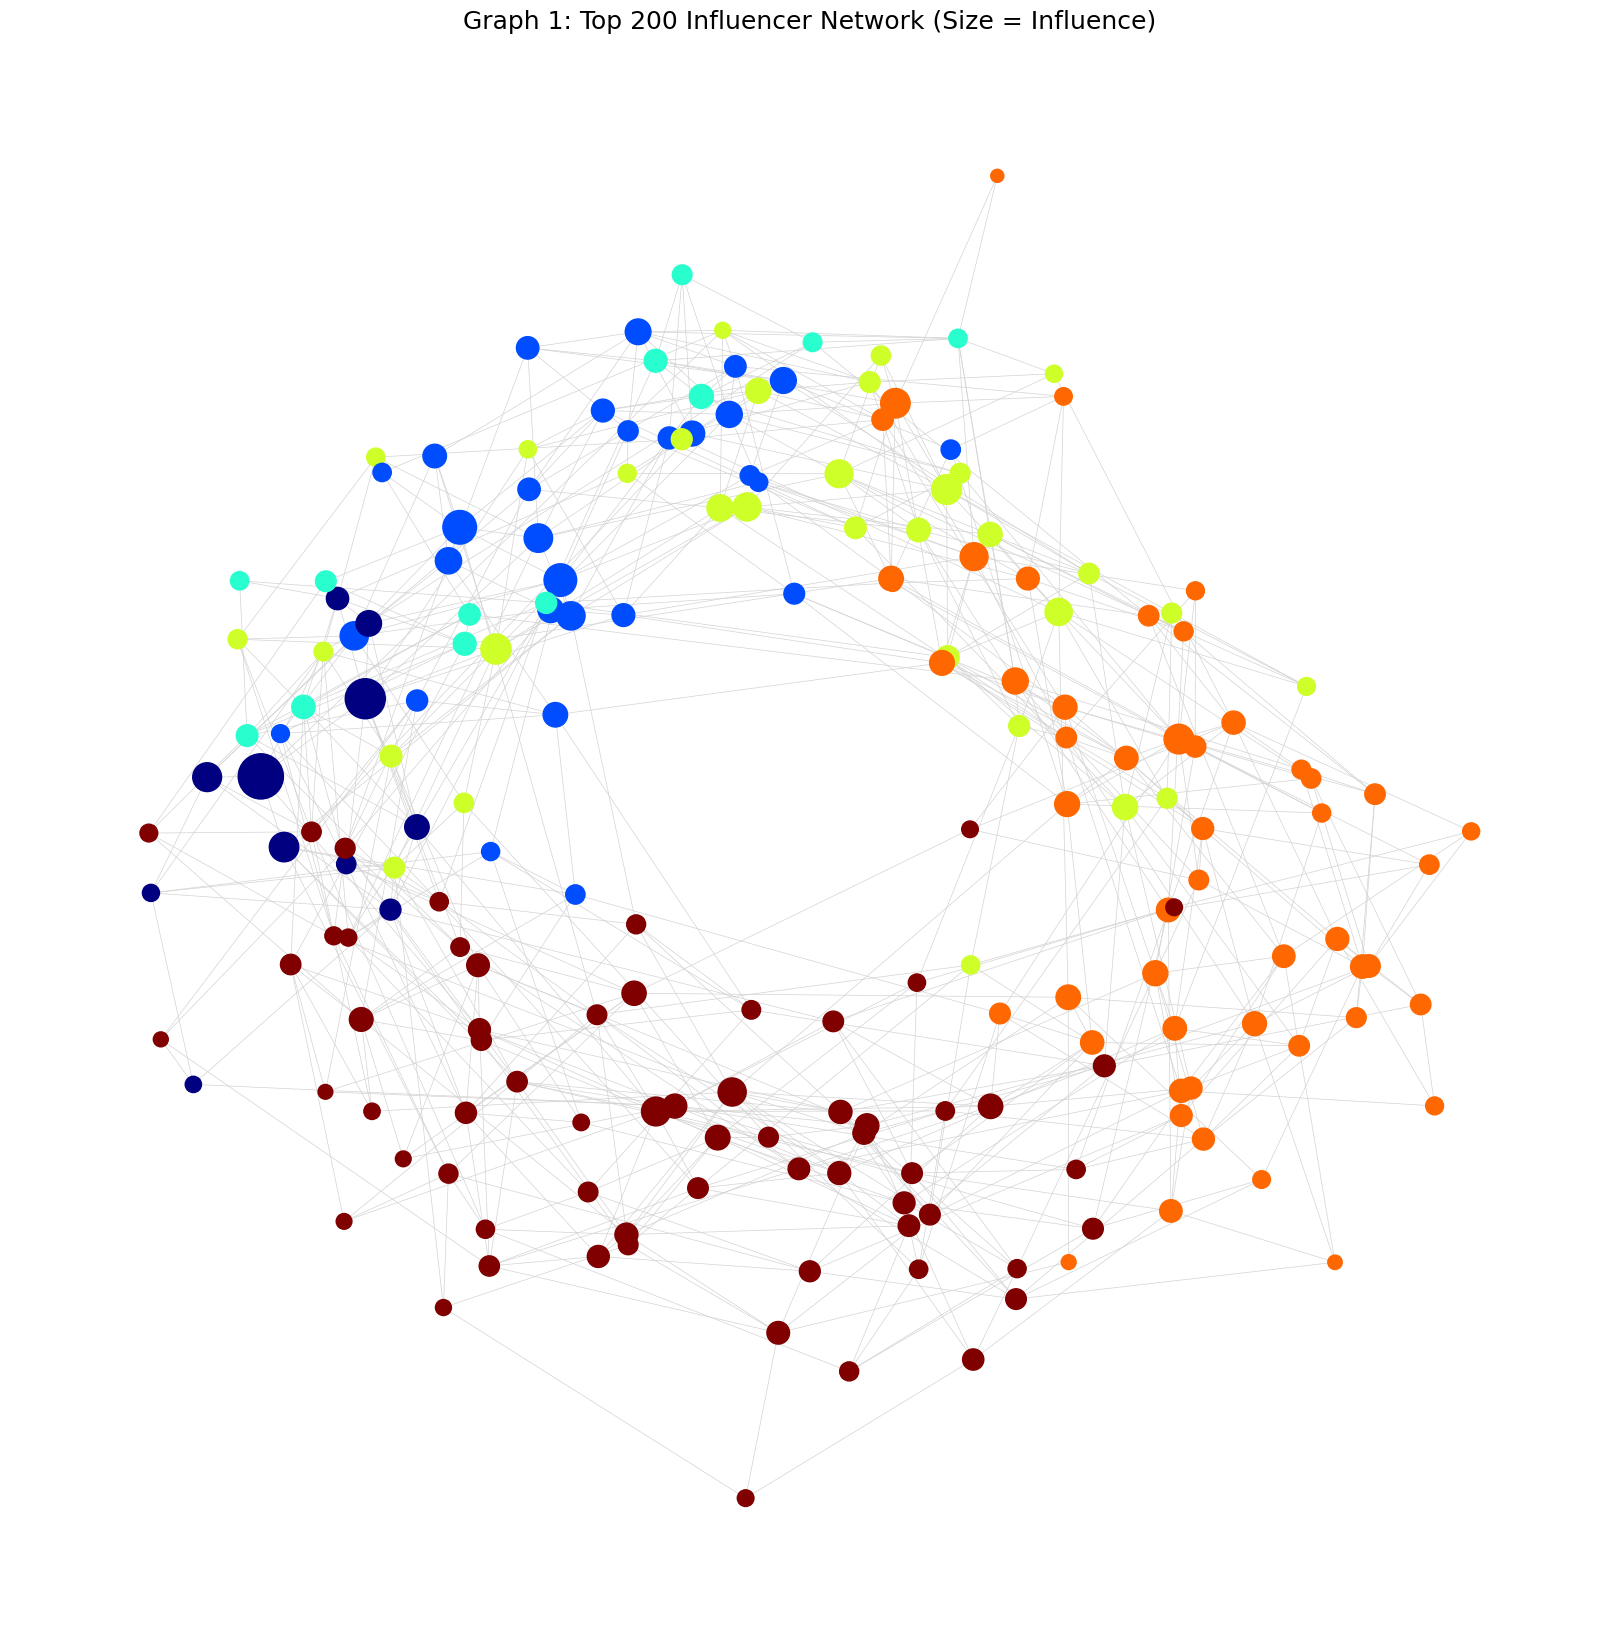

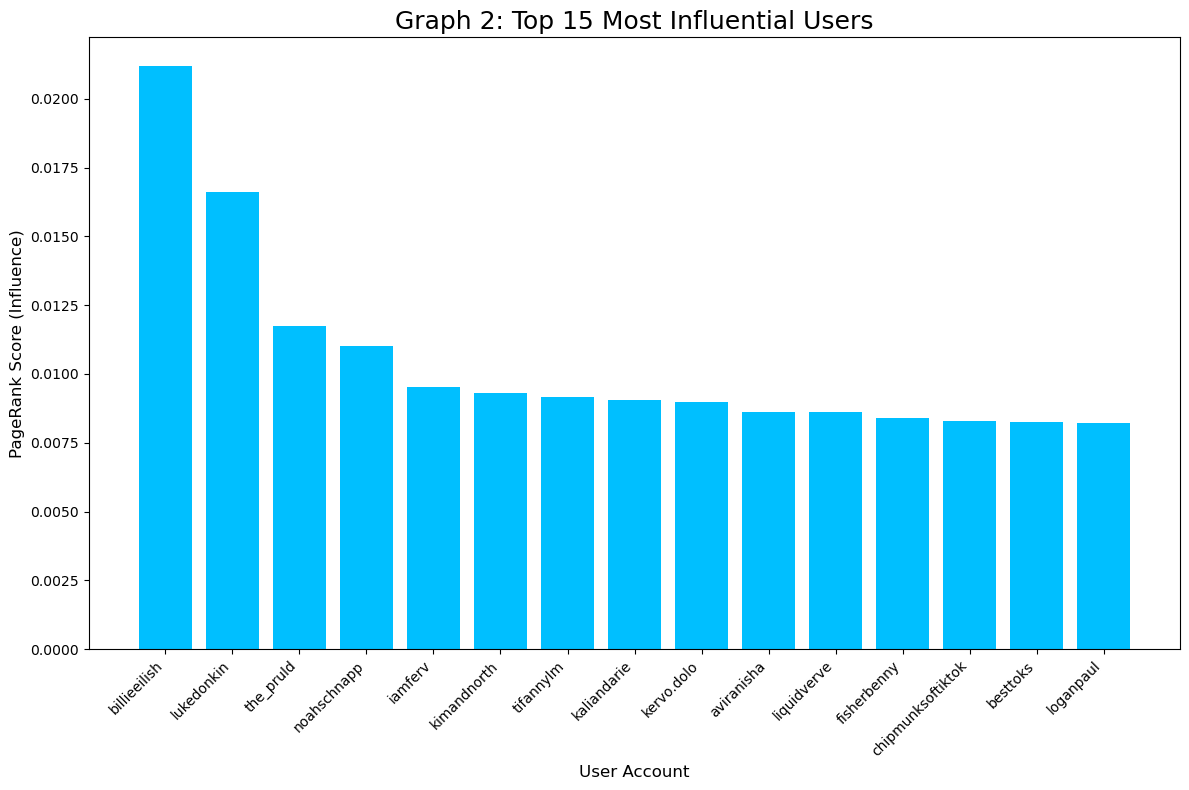

In [1]:
import pandas as pd
import networkx as nx
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
import numpy as np
import random

# --- Step 1: Load Real Dataset from Kaggle CSV ---
print("--- Step 1: Loading Real Influencer Data ---")
try:
    df = pd.read_csv('tiktok_top_1000.csv')
    df.dropna(subset=['Account'], inplace=True)
    df = df.head(200) # Work with Top 200 for manageable analysis
    print(f"Successfully loaded and prepared {len(df)} influencer records.")
except FileNotFoundError:
    print("Error: 'tiktok_top_1000.csv' not found.")
    exit()

# --- Step 2: Build Graph from Real Data ---
print("\n--- Step 2: Building Graph from Real Data ---")
G = nx.Graph()

for index, row in df.iterrows():
    G.add_node(
        row['Account'],
        name=row['Title'],
        subscribers=row['Subscribers count'],
        views_avg=row['Views avg.'],
        likes_avg=row['Likes avg.']
    )

print("Simulating network edges (follows)...")
accounts = list(df['Account'])
for i, account1 in enumerate(accounts):
    num_follows = random.randint(2, 5)
    for _ in range(num_follows):
        follow_distance = int(random.gauss(0, len(accounts) / 10))
        j = (i + follow_distance) % len(accounts)
        if i != j:
            account2 = accounts[j]
            weight = G.nodes[account2]['likes_avg']
            G.add_edge(account1, account2, weight=weight)

print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# --- Perform SNA Calculations ---
pagerank = nx.pagerank(G, weight='weight')
partition = community_louvain.best_partition(G, weight='weight')
betweenness = nx.betweenness_centrality(G, weight='weight')


# --- NEW: Simple Text-Based Analysis Outputs ---
print("\n\n--- SIMPLE TEXT-BASED ANALYSIS OUTPUTS ---\n")

# 1. Top 5 Bridge Users (Betweenness Centrality)
print("--- Top 5 Bridge Users (High Betweenness Centrality) ---")
print("These users often connect different clusters or communities within the network.")
sorted_betweenness = sorted(betweenness.items(), key=lambda item: item[1], reverse=True)
for user, score in sorted_betweenness[:5]:
    print(f"- {user}: Score {score:.4f}")
print("-" * 40)

# 2. Detecting communities using the Louvain method
print("\n--- Step 4: Detecting Communities (Louvain Method) ---")
communities = {}
for node, community_id in partition.items():
    communities.setdefault(community_id, []).append(node)
print(f"Detected {len(communities)} communities.")
# Print the largest 3 communities for brevity
sorted_communities = sorted(communities.values(), key=len, reverse=True)
for i, community in enumerate(sorted_communities[:3]):
    print(f"- Community {i+1} (Size: {len(community)}): {community[:5]}...") # Print first 5 members
print("-" * 40)

# 3. Predicting potential new links (follows)
print("\n--- Step 5: Predicting Potential New Links (Jaccard Coefficient) ---")
print("Suggests new 'follows' between users who are not yet connected but have similar friends.")
predictions = nx.jaccard_coefficient(G, ebunch=nx.non_edges(G))
sorted_predictions = sorted(predictions, key=lambda item: item[2], reverse=True)
print("Top 5 potential new connections to follow:")
for u, v, score in sorted_predictions[:5]:
    if score > 0:
        print(f"- Potential link between '{u}' and '{v}' with score: {score:.4f}")
print("-" * 40)

# 4. Generating FYP Recommendations
print("\n--- Step 6: Generating FYP Recommendations ---")
def generate_fyp_recommendations(user_name, graph, communities_partition, num_recs=5):
    if user_name not in graph:
        return f"User '{user_name}' not found in the network."
    
    # 1. Find user's community
    user_community_id = communities_partition[user_name]
    community_nodes = [node for node, cid in communities_partition.items() if cid == user_community_id]
    
    # 2. Find influential users in that community (excluding the user themselves)
    community_pagerank = {node: pagerank[node] for node in community_nodes if node != user_name}
    influencers_in_community = sorted(community_pagerank.items(), key=lambda item: item[1], reverse=True)
    
    # 3. Get accounts followed by these influencers
    recommendations = {}
    for influencer, score in influencers_in_community:
        # Neighbors of the influencer are the accounts they "follow" in our graph
        for neighbor in graph.neighbors(influencer):
            recommendations[neighbor] = recommendations.get(neighbor, 0) + score

    # 4. Filter out accounts the user already follows or the user themself
    user_follows = set(graph.neighbors(user_name))
    user_follows.add(user_name)
    
    final_recs = {acc: score for acc, score in recommendations.items() if acc not in user_follows}
    
    # Return the top N recommendations
    sorted_recs = sorted(final_recs.items(), key=lambda item: item[1], reverse=True)
    return [rec[0] for rec in sorted_recs[:num_recs]]

# Example: Get recommendations for the top user in our dataset
target_user = df['Account'].iloc[0]
recommendations = generate_fyp_recommendations(target_user, G, partition)
print(f"Follow recommendations for '{target_user}': {recommendations}")
print("-" * 40)


# --- ADVANCED GRAPHICAL PLOTS (from previous step) ---
print("\n\n--- GENERATING ADVANCED VISUALIZATIONS ---\nThis might take a moment...")

# Use a consistent position layout for all network graphs
pos = nx.spring_layout(G, seed=42, k=0.9)

# Graph 1: Full Network
plt.figure(figsize=(16, 16))
node_sizes = [pagerank[node] * 50000 for node in G.nodes()]
node_colors = [partition[node] for node in G.nodes()]
nx.draw(G, pos, with_labels=False, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.jet, edge_color='lightgray', width=0.5)
plt.title("Graph 1: Top 200 Influencer Network (Size = Influence)", size=18)
plt.show()

# Graph 2: Bar Chart
plt.figure(figsize=(12, 8))
top_15_pagerank = sorted(pagerank.items(), key=lambda item: item[1], reverse=True)[:15]
user_names = [name for name, score in top_15_pagerank]
scores = [score for name, score in top_15_pagerank]
plt.bar(user_names, scores, color='deepskyblue')
plt.xlabel("User Account", size=12)
plt.ylabel("PageRank Score (Influence)", size=12)
plt.title("Graph 2: Top 15 Most Influential Users", size=18)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

--- Step 1: Loading Real Influencer Data ---
Successfully loaded and prepared 200 influencer records.

--- Step 2: Building Graph from Real Data ---
Simulating network edges (follows)...
Graph created with 199 nodes and 645 edges.


--- SIMPLE TEXT-BASED ANALYSIS OUTPUTS ---

--- Top 5 Bridge Users (High Betweenness Centrality) ---
- gingerbilly1: Score 0.1158
- .raquel_e: Score 0.1080
- lai8747: Score 0.0586
- qamar_altaey: Score 0.0582
- nicocaponecomedy: Score 0.0571
----------------------------------------

--- Step 4: Detecting Communities (Louvain Method) ---
Detected 6 communities.
- Community 1 (Size: 60): ['the_pruld', 'isaiahgarza', 'amauryguichon', 'sofarsabi', 'c4tluvr666']...
- Community 2 (Size: 50): ['willsmith', 'jdpantoja', 'vhackerr', 'seventeen17_official', 'sucss.s']...
- Community 3 (Size: 44): ['txt.bighitent', 'machinegunkelly', 'khaby.lame', 'y_chun', 'domelipa']...
----------------------------------------

--- Step 5: Predicting Potential New Links (Jaccard Coe

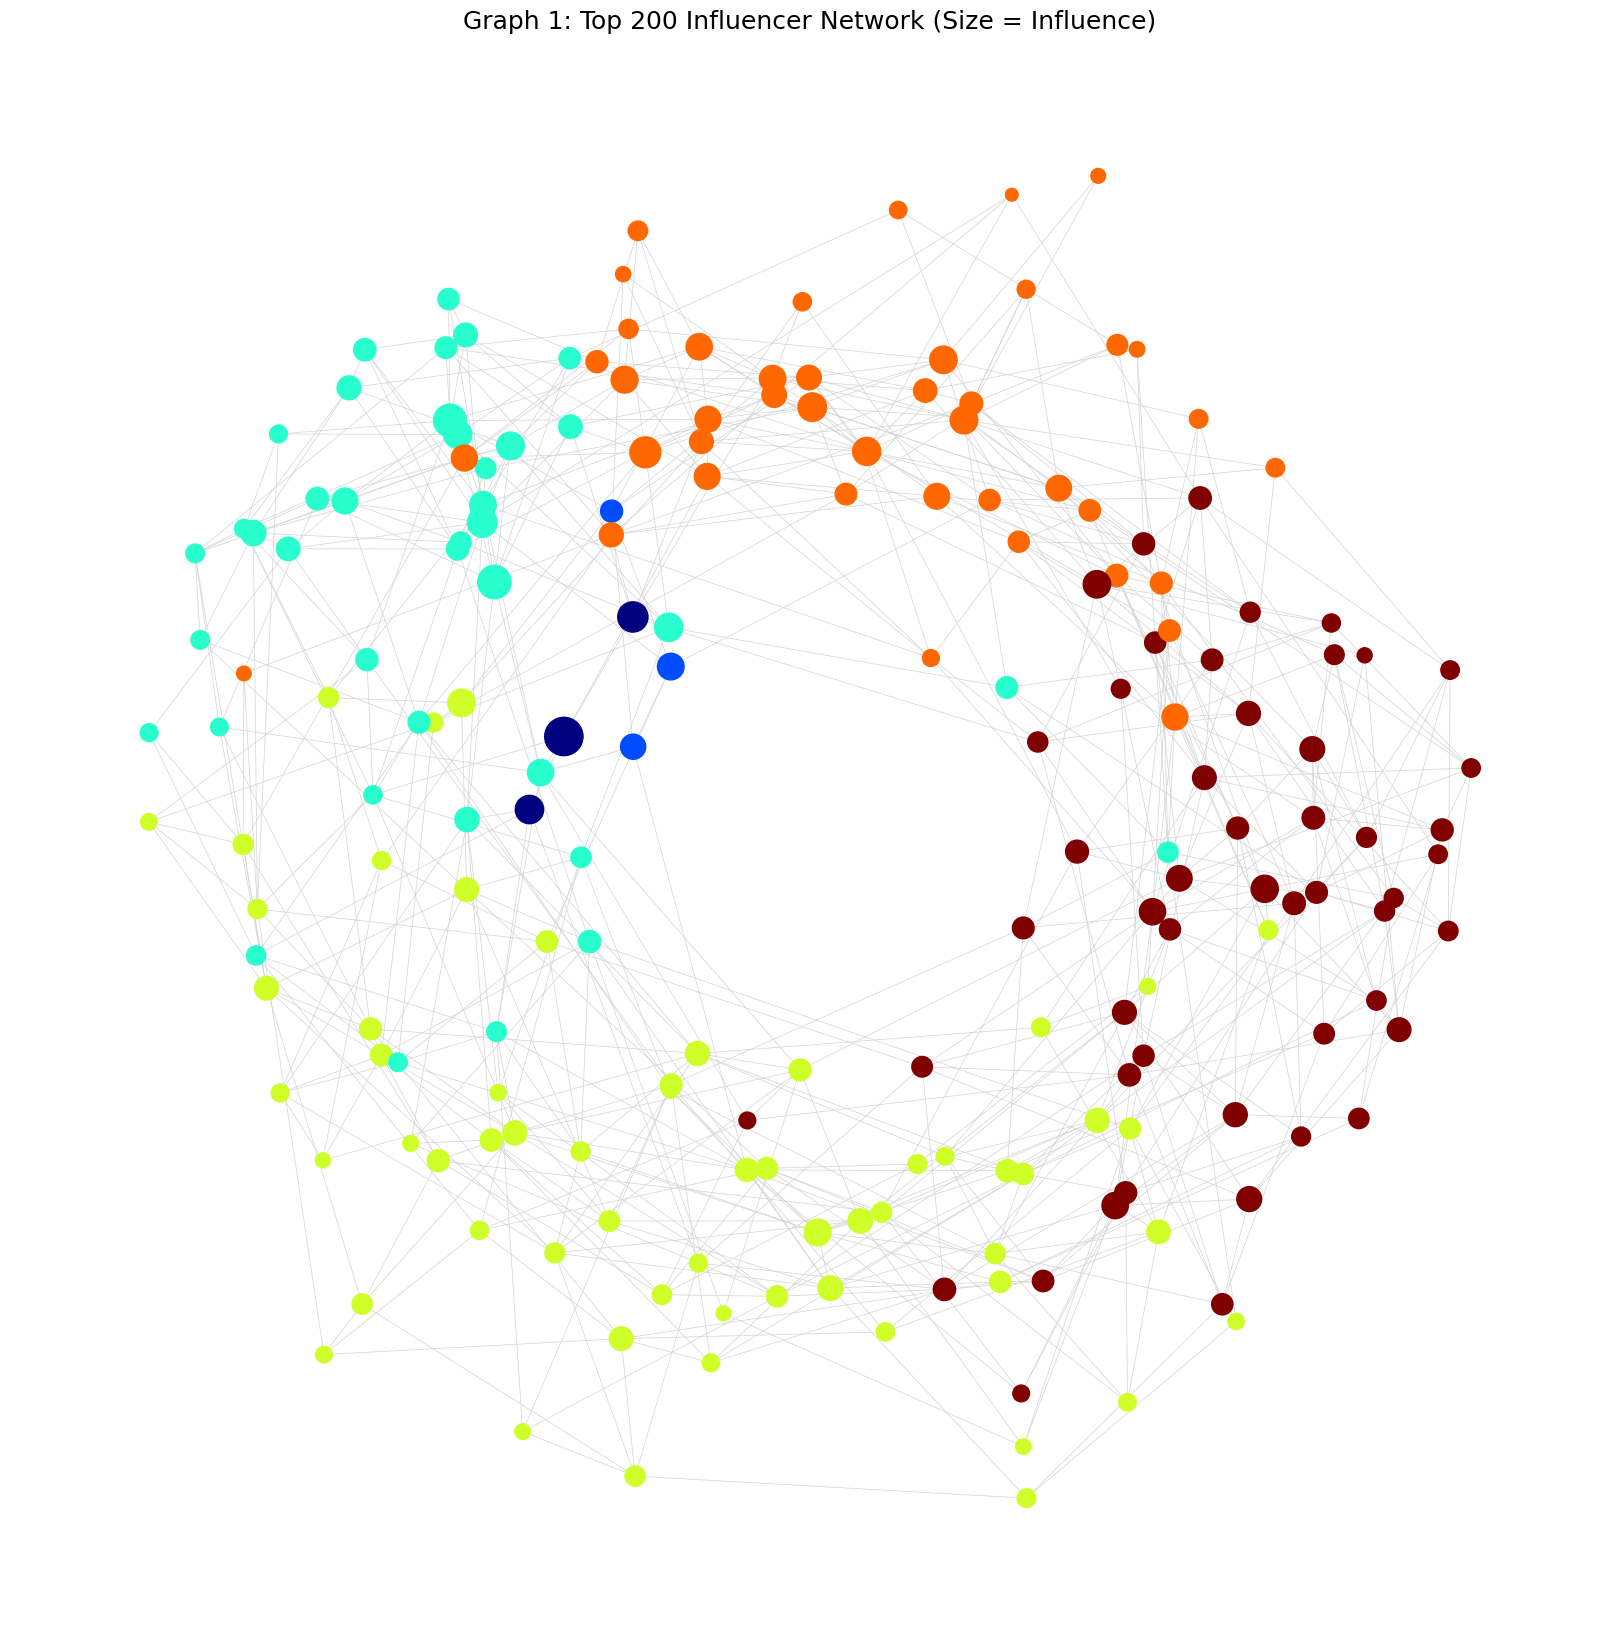

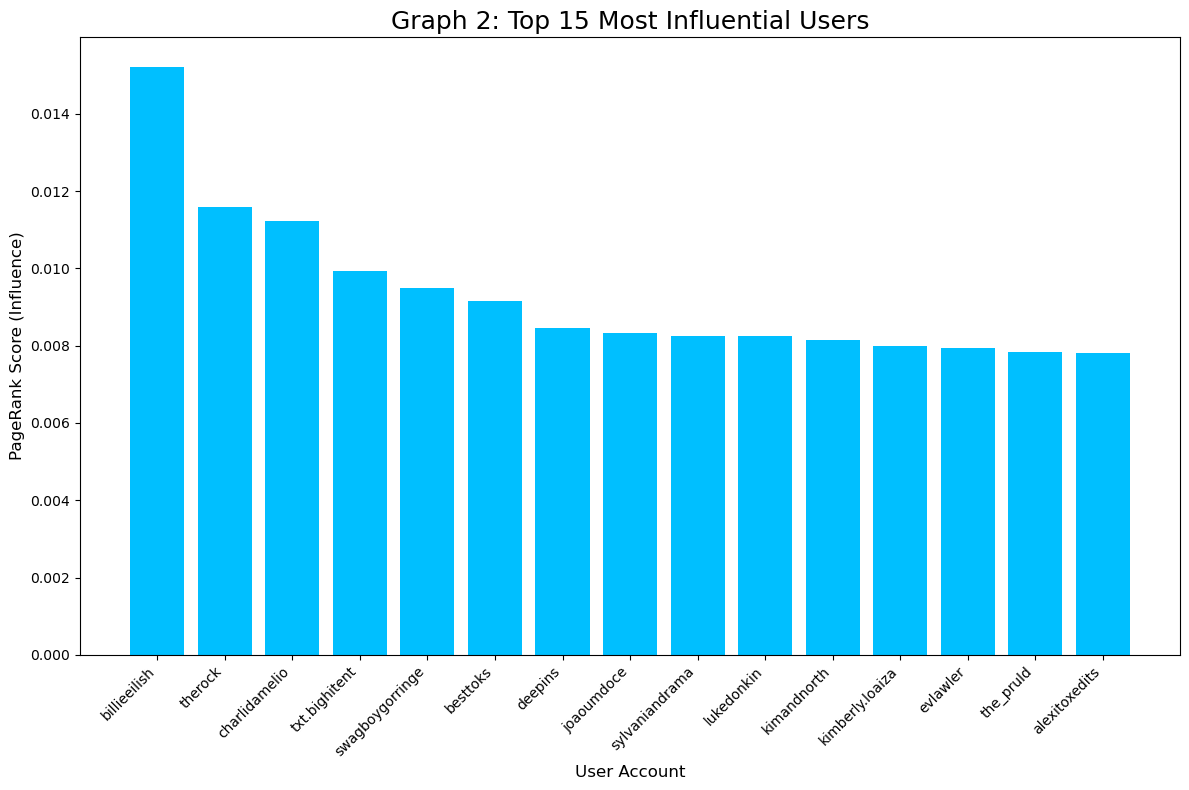

In [7]:
import pandas as pd
import networkx as nx
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
import numpy as np
import random

# --- Step 1: Load Real Dataset from Kaggle CSV ---
print("--- Step 1: Loading Real Influencer Data ---")
try:
    df = pd.read_csv('tiktok_top_1000.csv')
    df.dropna(subset=['Account'], inplace=True)
    df = df.head(200) # Work with Top 200 for manageable analysis
    print(f"Successfully loaded and prepared {len(df)} influencer records.")
except FileNotFoundError:
    print("Error: 'tiktok_top_1000.csv' not found.")
    print("Please download the file from https://www.kaggle.com/datasets/prasertk/top-1000-tiktok-influencers-ranking and place it in the same directory.")
    exit()

# --- Step 2: Build Graph from Real Data ---
print("\n--- Step 2: Building Graph from Real Data ---")
G = nx.Graph()

for index, row in df.iterrows():
    G.add_node(
        row['Account'],
        name=row['Title'],
        subscribers=row['Subscribers count'],
        views_avg=row['Views avg.'],
        likes_avg=row['Likes avg.']
    )

print("Simulating network edges (follows)...")
accounts = list(df['Account'])
for i, account1 in enumerate(accounts):
    num_follows = random.randint(2, 5)
    for _ in range(num_follows):
        follow_distance = int(random.gauss(0, len(accounts) / 10))
        j = (i + follow_distance) % len(accounts)
        if i != j:
            account2 = accounts[j]
            weight = G.nodes[account2]['likes_avg']
            G.add_edge(account1, account2, weight=weight)

print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# --- Perform SNA Calculations ---
pagerank = nx.pagerank(G, weight='weight')
partition = community_louvain.best_partition(G, weight='weight')
betweenness = nx.betweenness_centrality(G, weight='weight')


# --- SIMPLE TEXT-BASED ANALYSIS OUTPUTS ---
print("\n\n--- SIMPLE TEXT-BASED ANALYSIS OUTPUTS ---\n")

# 1. Top 5 Bridge Users
print("--- Top 5 Bridge Users (High Betweenness Centrality) ---")
sorted_betweenness = sorted(betweenness.items(), key=lambda item: item[1], reverse=True)
for user, score in sorted_betweenness[:5]:
    print(f"- {user}: Score {score:.4f}")
print("-" * 40)

# 2. Community Detection
print("\n--- Step 4: Detecting Communities (Louvain Method) ---")
communities = {}
for node, community_id in partition.items():
    communities.setdefault(community_id, []).append(node)
print(f"Detected {len(communities)} communities.")
sorted_communities = sorted(communities.values(), key=len, reverse=True)
for i, community in enumerate(sorted_communities[:3]):
    print(f"- Community {i+1} (Size: {len(community)}): {community[:5]}...")
print("-" * 40)

# 3. Link Prediction
print("\n--- Step 5: Predicting Potential New Links (Jaccard Coefficient) ---")
predictions = nx.jaccard_coefficient(G, ebunch=nx.non_edges(G))
sorted_predictions = sorted(predictions, key=lambda item: item[2], reverse=True)
print("Top 5 potential new connections to follow:")
for u, v, score in sorted_predictions[:5]:
    if score > 0:
        print(f"- Potential link between '{u}' and '{v}' with score: {score:.4f}")
print("-" * 40)

# 4. Generating FYP Recommendations for Top 10 Users
print("\n--- Step 6: Generating FYP Recommendations for Top 10 Users ---")
def generate_fyp_recommendations(user_name, graph, communities_partition, num_recs=5):
    if user_name not in graph:
        return f"User '{user_name}' not found in the network."
    
    user_community_id = communities_partition[user_name]
    community_nodes = [node for node, cid in communities_partition.items() if cid == user_community_id]
    community_pagerank = {node: pagerank[node] for node in community_nodes if node != user_name}
    influencers_in_community = sorted(community_pagerank.items(), key=lambda item: item[1], reverse=True)
    
    recommendations = {}
    for influencer, score in influencers_in_community:
        for neighbor in graph.neighbors(influencer):
            recommendations[neighbor] = recommendations.get(neighbor, 0) + score

    user_follows = set(graph.neighbors(user_name))
    user_follows.add(user_name)
    
    final_recs = {acc: score for acc, score in recommendations.items() if acc not in user_follows}
    
    sorted_recs = sorted(final_recs.items(), key=lambda item: item[1], reverse=True)
    return [rec[0] for rec in sorted_recs[:num_recs]]

# *** THIS IS THE MODIFIED SECTION ***
# Loop through the top 10 users from the dataframe and generate recommendations
top_10_users = df['Account'].head(10).tolist()
for user in top_10_users:
    user_recommendations = generate_fyp_recommendations(user, G, partition)
    print(f"- Recommendations for '{user}': {user_recommendations}")
print("-" * 40)


# --- ADVANCED GRAPHICAL PLOTS ---
print("\n\n--- GENERATING ADVANCED VISUALIZATIONS ---\nThis might take a moment...")

# Use a consistent position layout for all network graphs
pos = nx.spring_layout(G, seed=42, k=0.9)

# Graph 1: Full Network
plt.figure(figsize=(16, 16))
node_sizes = [pagerank[node] * 50000 for node in G.nodes()]
node_colors = [partition[node] for node in G.nodes()]
nx.draw(G, pos, with_labels=False, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.jet, edge_color='lightgray', width=0.5)
plt.title("Graph 1: Top 200 Influencer Network (Size = Influence)", size=18)
plt.show()

# Graph 2: Bar Chart
plt.figure(figsize=(12, 8))
top_15_pagerank = sorted(pagerank.items(), key=lambda item: item[1], reverse=True)[:15]
user_names = [name for name, score in top_15_pagerank]
scores = [score for name, score in top_15_pagerank]
plt.bar(user_names, scores, color='deepskyblue')
plt.xlabel("User Account", size=12)
plt.ylabel("PageRank Score (Influence)", size=12)
plt.title("Graph 2: Top 15 Most Influential Users", size=18)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()